In [50]:
R.version

               _                           
platform       x86_64-conda_cos6-linux-gnu 
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          3                           
minor          6.1                         
year           2019                        
month          07                          
day            05                          
svn rev        76782                       
language       R                           
version.string R version 3.6.1 (2019-07-05)
nickname       Action of the Toes          

In [51]:
library("dplyr")
library("glue")
library("stringr")
library("rlist")
library("data.table")
library("readr")
library("stringi")
library("swat")

In [52]:
source("UtilsRCAS.R")

# Connection a l'environnement SAS Viya

In [53]:
#cashost <- '192.168.1.50'
#casuser <- 'sasdemo'

cashost <- 'controller'
casuser <- 'sebastien'

conn <- swat::CAS(cashost, 5570, username=casuser)

# Activate metric tracing and other session parameters
out <- cas.sessionProp.setSessOpt(conn, metrics=TRUE, timeout=1800, caslib='casuser')

NOTE: Connecting to CAS and generating CAS action functions for loaded
      action sets...
NOTE: To generate the functions with signatures (for tab completion), set 
      options(cas.gen.function.sig=TRUE).
NOTE: 'CASUSER(sebastien)' is now the active caslib.
NOTE: Action 'sessionProp.setSessOpt' used (Total process time):
NOTE:       real time               0.016321 seconds
NOTE:       cpu time                0.025514 seconds (156.33%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  1.44M (0.00%)


In [54]:
actionsets <- c('fedsql','aggregation')
for(i in actionsets){
    loadActionSet(conn, i)
}

NOTE: Executing action 'builtins.loadActionSet'.
NOTE: Added action set 'fedsql'.
NOTE: Action 'builtins.loadActionSet' used (Total process time):
NOTE:       real time               0.141540 seconds
NOTE:       cpu time                0.031257 seconds (22.08%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  1.29M (0.00%)
NOTE: Executing action 'builtins.actionSetInfo'.
NOTE: Action 'builtins.actionSetInfo' used (Total process time):
NOTE:       real time               0.054094 seconds
NOTE:       cpu time                0.016157 seconds (29.87%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  1.62M (0.00%)
NOTE: Executing action 'builtins.listActions'.
NOTE: Information for action set 'fedSql':
NOTE:    fedSql
NOTE:       execDirect - Submits a SAS FedSQL language statement for immediate execution
NOTE: Action 'builtins.listA

In [55]:
cas.builtins.serverStatus(conn)

NOTE: Executing action 'builtins.serverStatus'.
NOTE: Grid node action status report: 5 nodes, 34 total actions executed.
NOTE: Action 'builtins.serverStatus' used (Total process time):
NOTE:       real time               0.008073 seconds
NOTE:       cpu time                0.015344 seconds (190.07%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  1.42M (0.00%)


$About
$About$CAS
[1] "Cloud Analytic Services"

$About$Version
[1] "3.05"

$About$VersionLong
[1] "V.03.05M0P11112019"

$About$Copyright
[1] "Copyright © 2014-2018 SAS Institute Inc. All Rights Reserved."

$About$ServerTime
[1] "2020-04-28T16:48:19Z"

$About$System
$About$System$Hostname
[1] "controller.c.sas-ag2r-la-mondiale.internal"

$About$System$`OS Name`
[1] "Linux"

$About$System$`OS Family`
[1] "LIN X64"

$About$System$`OS Release`
[1] "3.10.0-1062.18.1.el7.x86_64"

$About$System$`OS Version`
[1] "#1 SMP Tue Mar 17 23:49:17 UTC 2020"

$About$System$`Model Number`
[1] "x86_64"

$About$System$`Linux Distribution`
[1] "CentOS Linux release 7.8.2003 (Core)"


$About$license
$About$license$site
[1] "BDF"

$About$license$siteNum
[1] 70180938

$About$license$expires
[1] "27Mar2021:00:00:00"

$About$license$gracePeriod
[1] 45

$About$license$warningPeriod
[1] 47

$About$license$maxCPUs
[1] 9999



$server
  nodes actions
1     5      34

$nodestatus
                                        name       role uptime running stalled
1    worker1.c.sas-ag2r-la-mondiale.internal     worker  1.794       0       0
2    worker2.c.sas-ag2r-la-mondiale.internal     worker  1.794       0       0
3    worker3.c.sas-ag2r-la-mondiale.internal     worker  1.794       0       0
4    worker4.c.sas-ag2r-la-mondiale.internal     worker  1.794       0       0
5 controller.c.sas-ag2r-la-mondiale.internal controller  1.871       0       0

## Defini une librairie CAS pointant sur le repertoire contenant tous les fichiers CSV en entree. On definie la source en DNFS, cela signifie que la lecture et l'ecriture des fichiers se fera en multitheading et multi noeud automatiquement. Les formats de fichiers supportes actuellement sur ce mode sont : CSV, PARQUET et SASHDAT.

In [56]:
HeureDebut <- Sys.time()

#cas.table.addCaslib(conn,name="mycaslib", path="/data/data/BDF_SMALL_DB", dataSource={srcType="dnfs"})
#cas.table.addCaslib(conn,name="mycaslib", path="/SAS/BDF", dataSource={srcType="dnfs"})
out <- cas.sessionProp.setSessOpt(conn,caslib='casuser')

NOTE: Executing action 'sessionProp.setSessOpt'.
NOTE: 'CASUSER(sebastien)' is now the active caslib.
NOTE: Action 'sessionProp.setSessOpt' used (Total process time):
NOTE:       real time               0.008207 seconds
NOTE:       cpu time                0.017112 seconds (208.50%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  1.28M (0.00%)


# Chargement en memoire de tous les fichiers CSV en entree (referentiel et agregats) pour l'utilisation ulterieure.

In [57]:
import_all_csv_in_memory(conn, 'BDF_ORACLE','casuser',fileflag=0)

NOTE: Executing action 'table.fileInfo'.
NOTE: Action 'table.fileInfo' used (Total process time):
NOTE:       real time               1.331958 seconds
NOTE:       cpu time                0.051753 seconds (3.89%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  1.99M (0.00%)
NOTE: Executing action 'table.dropTable'.
NOTE: Action 'table.dropTable' used (Total process time):
NOTE:       real time               0.012174 seconds
NOTE:       cpu time                0.018133 seconds (148.95%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  1.38M (0.00%)
NOTE: Executing action 'table.loadTable'.
NOTE: Performing serial LoadTable action using SAS Data Connector to Oracle.
NOTE: Cloud Analytic Services made the external data from CREDITCARD available as table CREDITCARD in caslib CASUSER(sebastien).
NOTE: Action 'table.loadTable' used (T

In [58]:
cas.table.tableInfo(conn,caslib="casuser")

NOTE: Executing action 'table.tableInfo'.
NOTE: Action 'table.tableInfo' used (Total process time):
NOTE:       real time               0.009322 seconds
NOTE:       cpu time                0.016312 seconds (174.98%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  1.87M (0.00%)


Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
CREDITCARD,284807,32,0,utf-8,2020-04-28T16:48:21+00:00,2020-04-28T16:48:21+00:00,2020-04-28T16:48:21+00:00,UTF8,1903711701,...,0,0,0,CREDITCARD,BDF_ORACLE,0,sebastien,,,NaN
D,32038933,9,0,utf-8,2020-04-28T16:48:23+00:00,2020-04-28T16:48:23+00:00,2020-04-28T16:48:23+00:00,UTF8,1903711703,...,0,0,0,D,BDF_ORACLE,0,sebastien,,,NaN
D1,21648241,9,0,utf-8,2020-04-28T16:50:59+00:00,2020-04-28T16:50:59+00:00,2020-04-28T16:50:59+00:00,UTF8,1903711859,...,0,0,0,D1,BDF_ORACLE,0,sebastien,,,NaN
D2,6472521,9,0,utf-8,2020-04-28T16:52:48+00:00,2020-04-28T16:52:48+00:00,2020-04-28T16:52:48+00:00,UTF8,1903711968,...,0,0,0,D2,BDF_ORACLE,0,sebastien,,,NaN
D3,18196935,9,0,utf-8,2020-04-28T16:53:18+00:00,2020-04-28T16:53:18+00:00,2020-04-28T16:53:18+00:00,UTF8,1903711998,...,0,0,0,D3,BDF_ORACLE,0,sebastien,,,NaN
F,597409,9,0,utf-8,2020-04-28T16:54:35+00:00,2020-04-28T16:54:35+00:00,2020-04-28T16:54:35+00:00,UTF8,1903712075,...,0,0,0,F,BDF_ORACLE,0,sebastien,,,NaN
O,28344903,9,0,utf-8,2020-04-28T16:54:38+00:00,2020-04-28T16:54:38+00:00,2020-04-28T16:54:38+00:00,UTF8,1903712078,...,0,0,0,O,BDF_ORACLE,0,sebastien,,,NaN
P,9530865,9,0,utf-8,2020-04-28T16:56:43+00:00,2020-04-28T16:56:43+00:00,2020-04-28T16:56:43+00:00,UTF8,1903712203,...,0,0,0,P,BDF_ORACLE,0,sebastien,,,NaN
PLANAGREGATION,533,42,0,utf-8,2020-04-28T16:57:32+00:00,2020-04-28T16:57:32+00:00,2020-04-28T16:57:32+00:00,UTF8,1903712252,...,0,0,0,PLANAGREGATION,BDF_ORACLE,0,sebastien,,,NaN
TABLEPAYSZONE,3953,6,0,utf-8,2020-04-28T16:57:33+00:00,2020-04-28T16:57:33+00:00,2020-04-28T16:57:33+00:00,UTF8,1903712253,...,0,0,0,TABLEPAYSZONE,BDF_ORACLE,0,sebastien,,,NaN


## Concatenation totale de toutes les tables d'agregat en mémoire pour former une table nommee AGGTTECATEGORIE

In [59]:
cas_concat_all_tables(conn, "casuser","casuser","AGGTTECATEGORIE")
table_AggregationMensuelleTouteCategorie <- defCasTable(conn, tablename='AGGTTECATEGORIE', caslib='casuser')
nrow(table_AggregationMensuelleTouteCategorie)

NOTE: Executing action 'table.tableInfo'.
NOTE: Action 'table.tableInfo' used (Total process time):
NOTE:       real time               0.010422 seconds
NOTE:       cpu time                0.016769 seconds (160.90%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  1.87M (0.00%)
NOTE: Executing action 'table.dropTable'.
NOTE: Action 'table.dropTable' used (Total process time):
NOTE:       real time               0.014370 seconds
NOTE:       cpu time                0.017270 seconds (120.18%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  1.41M (0.00%)
NOTE: Executing action 'dataStep.runCode'.
NOTE: Action 'dataStep.runCode' used (Total process time):
NOTE:       real time               1.984022 seconds
NOTE:       cpu time                67.273767 seconds (3390.78%)
NOTE:       total nodes             5 (68 cores)
NOTE:       t

[1] 157620504

## Produire la repartition en nombre d'enregistrements par categorie a partir de l'agregation faite en memoire par le moteur CAS sur la table globale AGGTTECATEGORIE et la recuperation de ces agregats en entree de la fonction PIE de R

NOTE: Executing action 'simple.freq'.
NOTE: Action 'simple.freq' used (Total process time):
NOTE:       real time               0.862491 seconds
NOTE:       cpu time                48.368423 seconds (5607.99%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  75.34M (0.01%)
NOTE:       bytes moved             1.45K


casLib,Name,Rows,Columns
CASUSER(sebastien),AGGTTECATEGORIE_freq,11,5


NOTE: Executing action 'table.fetch'.
NOTE: Action 'table.fetch' used (Total process time):
NOTE:       real time               0.027849 seconds
NOTE:       cpu time                0.061410 seconds (220.51%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  6.14M (0.00%)


$Fetch
   _Index_  _Column_ _Charvar_ _Fmtvar_ _Level_ _Frequency_
1        1 tablename         D        D       7    32038933
2        2 tablename         O        O       5    28344903
3        3 tablename        D1       D1       9    21648241
4        4 tablename        D3       D3       4    18196935
5        5 tablename        U1       U1      11    14835007
6        6 tablename        U2       U2       1    13390747
7        7 tablename         P        P      10     9530865
8        8 tablename         Z        Z       3     6486954
9        9 tablename        D2       D2       8     6472521
10      10 tablename        U3       U3       2     6077989
11      11 tablename         F        F       6      597409



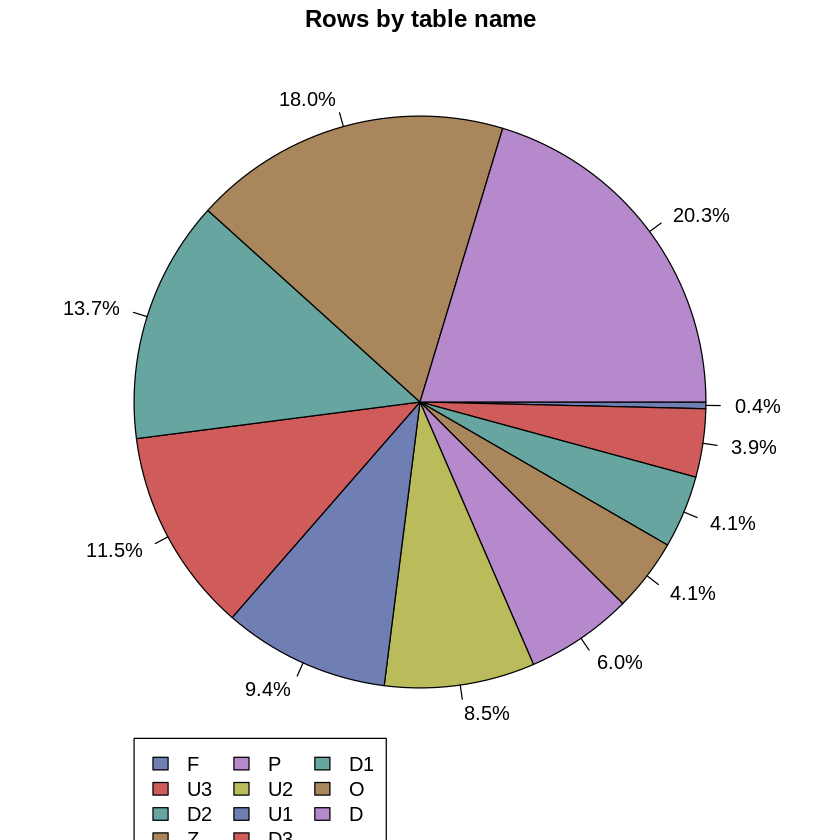

In [60]:
cas.simple.freq(conn, inputs = c("tablename"),table = c(name = "AGGTTECATEGORIE"),casout = c(name = "AGGTTECATEGORIE_freq", replace = TRUE)) 
res <- cas.table.fetch(conn, table = "AGGTTECATEGORIE_freq", sortBy = list(list(name = "_Frequency_",order = "descending")))
print(res)
piedata <- res$Fetch                                              # 
names(piedata) <- gsub("_", "", names(piedata))
piedata <- piedata[order(piedata$Frequency),]
total <- sum(piedata$Frequency)
piedata$Percent <- scales::percent(piedata$Frequency / total)
fillcolors = c("#6F7EB3", "#D05B5B", "#66A5A0", "#A9865B","#B689CD", "#BABC5C")
par(mar = c(3, 0, 1.5, 0), xpd=TRUE)
pie(piedata$Frequency,labels = piedata$Percent, col=fillcolors, radius=0.85, clockwise=TRUE, init.angle=0, main="Rows by table name")
legend(x=-0.85, y=-1, horiz = FALSE, piedata$Charvar, fill = fillcolors, ncol=3)

## Declaration des table CAS en tant qu'objet de type CASTable en R

In [61]:
table_pays_zone <- defCasTable(conn, tablename='TABLEPAYSZONE', caslib='casuser')
table_planAggregation <- defCasTable(conn, tablename='PLANAGREGATION', caslib='casuser')

NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.013834 seconds
NOTE:       cpu time                0.019085 seconds (137.96%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  2.52M (0.00%)
NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.008569 seconds
NOTE:       cpu time                0.018018 seconds (210.27%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  2.52M (0.00%)


# Code principal basé sur le programme R existant

## Fonction de traitement principal

In [62]:
traitement_principal <- function(freq, RevFin, PeriodeFin, planAggregation,ReferencePiZones, Repertoire, ConnectionSecureDB)
{
  Frequence <- freq
  HeureDebut <- Sys.time()
  An = as.numeric(ExtractString(PeriodeFin, 1, 4))
  print("ETAPE DATA: LECTURE TABLE PI_ZONE")
  print(Sys.time())
  TablePiZone <- recuperation_traitement_table_code_pays(ReferencePiZones, ConnectionSecureDB)
  #return(TablePiZone)
  print(" TAILLE TABLE TablePaysZone")
  print(dim(TablePiZone))
  print(Sys.time())
  print("LECTURE ET MISE EN FORME DES FICHIERS D'AGGREGATION CODE SERIE")
  print(Sys.time())
  # planAggregation <- "PlanAggregation.csv"
  planAgregationCodeSerie <- lecture_fichier_aggregation_codeSerie(planAggregation, connectionSecureDB)
  # # write_delim(planAgregationCodeSerie, "planAgregationCodeSerie.csv", delim=";")
  print(" TAILLE TABLE planAgregationCodeSerie")
  print(dim(planAgregationCodeSerie))
  print(Sys.time())
  print("JOINTURE PLAN D'AGGREGATION")
  PlanAggregationParametre <- parametrage_aggregation_code_serie(planAgregationCodeSerie, TablePiZone, freq) 
    
  # # write_delim(PlanAggregationParametre, "PlanAggregationParametre.csv", delim=";")
  print("Taille plan d'agregation")
  print(dim(PlanAggregationParametre))
  print(names(PlanAggregationParametre))

  # Ecriture du dataframe de sortie en table CAS pour les futures jointures
  PlanAggregationParametreCAS <- as.casTable(ConnectionSecureDB, PlanAggregationParametre, casOut=list(caslib="casuser", name="PLANAGGPARAM",replace=TRUE))
  print(dim(PlanAggregationParametreCAS))
    
  print("ESTIMATION NOMBRE DE PERIODE ET DE DEBUT DE TRAITEMENT")
  result_nbperiode_moisdebut <- detection_nbPeriode_moisDebut(freq, RevFin, PeriodeFin)
  NbrePeriode <- result_nbperiode_moisdebut$nbper
  MoisDebut <- as.numeric(result_nbperiode_moisdebut$moisDebut)
  print(MoisDebut)
  
  rm(result_nbperiode_moisdebut)
  
  print("BOUCLE DU LES MOIS")

 # On supprime la table d'agregat finale si elle existe avant de la reconstruire de la boucle mensuelle suivante   
 cas.table.dropTable(conn, caslib='casuser', name='AGG_FINALE', quiet=TRUE)
    
  for(mois in MoisDebut:(MoisDebut+NbrePeriode-1))
  {
     print(paste0("     Mois debut ", MoisDebut))
     print(paste0("     Mois fin ", (MoisDebut+NbrePeriode-1)))
     print(paste0("     Mois en cours de traitement: ", mois))
     
     print(Sys.time())
     
     print("                      lecture")

     AggregationMensuelleTouteCategorie <- lecture_tables_aggregation(freq, Mois, RevFin, PeriodeFin, Repertoire, ConnectionSecureDB,'AGGTTECATEGORIE','AGG_MENS_TEMP')
     print("Taille table d'agregation")
     print(dim(AggregationMensuelleTouteCategorie))
     print(names(AggregationMensuelleTouteCategorie))
      
     TableIdMixte <- lecture_tables_mixte(freq, Mois, RevFin, PeriodeFin, Repertoire, ConnectionSecureDB,'AGGTTECATEGORIE','AGG_MIXTE')
     print(dim(TableIdMixte))
     print(names(TableIdMixte))
     print(Sys.time())
     
     print("PARAMETRAGE CODE SERIE") 
     
     print("APPLICATION PARAMETRAGE CODE SERIE") 
     
     AggregationCodeSerieFinaleMensuelle <- application_plan_parametrage_aggregation_code_serie_mensuel('AGG_MENS_TEMP', 'PLANAGGPARAM', ConnectionSecureDB,'AGG_MENS')
     print(names(AggregationCodeSerieFinaleMensuelle))
      
     # On ajoute la table mensuelle à la table globale finale
     cas_append2tables(conn, 'casuser', 'AGG_MENS', 'casuser', 'AGG_FINALE')
  }
}

## Definition des variables

In [63]:
Repertoire <- "AC156203"
RevFin<- "SD10"
PeriodeFin <- "2018Q4"
freq <- "Q"
planAggregation <- table_planAggregation
ReferencePiZones <- table_pays_zone
ConnectionSecureDB <- conn # Connexion securisee a la session CAS

In [64]:
traitement_principal(freq, RevFin, PeriodeFin, planAggregation,ReferencePiZones, Repertoire, ConnectionSecureDB)

[1] "ETAPE DATA: LECTURE TABLE PI_ZONE"
[1] "2020-04-28 17:00:59 UTC"
[1] "recuperation_traitement_table_code_pays monostream"
[1] "2020-04-28 17:00:59 UTC"


NOTE: Executing action 'table.fetch'.
NOTE: Action 'table.fetch' used (Total process time):
NOTE:       real time               0.330776 seconds
NOTE:       cpu time                0.334142 seconds (101.02%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  21.64M (0.00%)
Column 1 ['code_zone'] of item 2 is missing in item 1. Use fill=TRUE to fill with NA (NULL for list columns), or use.names=FALSE to ignore column names. use.names='check' (default from v1.12.2) emits this message and proceeds as if use.names=FALSE for  backwards compatibility. See news item 5 in v1.12.2 for options to control this message.


[1] "end recuperation_traitement_table_code_pays monostream"
[1] "2020-04-28 17:01:04 UTC"
[1] " TAILLE TABLE TablePaysZone"
[1] 445   3
[1] "2020-04-28 17:01:04 UTC"
[1] "LECTURE ET MISE EN FORME DES FICHIERS D'AGGREGATION CODE SERIE"
[1] "2020-04-28 17:01:04 UTC"
[1] "lecture_fichier_aggregation_codeSerie monostream"


NOTE: Executing action 'table.fetch'.
NOTE: Action 'table.fetch' used (Total process time):
NOTE:       real time               0.123966 seconds
NOTE:       cpu time                0.147667 seconds (119.12%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  27.40M (0.01%)


[1] " TAILLE TABLE planAgregationCodeSerie"
[1] 2697    3
[1] "2020-04-28 17:01:07 UTC"
[1] "JOINTURE PLAN D'AGGREGATION"
[1] "parametrage_aggregation_code_serie monostream"
[1] "2020-04-28 17:01:07 UTC"
[1] "Recuperation des positions et longueur parents dans les codes"
[1] "Recuperation des positions et longueur des parametres dans les codes"
[1] "2020-04-28 17:01:08 UTC"
[1] "Recuperation des positions et longueur des index dans les codes"
[1] "2020-04-28 17:01:08 UTC"
[1] "38 GB"
[1] "Creation des variables cd2_, cd3_, cd1_, refsec, countsec par decoupage des codes"
[1] "2020-04-28 17:01:09 UTC"
[1] "Modification conditionnelle des valeurs de code entree et code sortie"
[1] "2020-04-28 17:01:09 UTC"
[1] "Jointure de la table AggregationTable TablePiZone"
[1] 7125   20
 [1] "code_sortie"       "code_entree"       "formule"          
 [4] "enfants"           "parents"           "cle"              
 [7] "ind_"              "PositionEnfant"    "LongueurEnfant"   
[10] "PositionParametr

Warning message in if (class(data) == "character") {:
“the condition has length > 1 and only the first element will be used”NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.008646 seconds
NOTE:       cpu time                0.017843 seconds (206.37%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  2.52M (0.00%)
NOTE: Executing action 'simple.numRows'.
NOTE: Action 'simple.numRows' used (Total process time):
NOTE:       real time               0.010599 seconds
NOTE:       cpu time                0.019360 seconds (182.66%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  2.04M (0.00%)


[1] 2639427       3
[1] "ESTIMATION NOMBRE DE PERIODE ET DE DEBUT DE TRAITEMENT"
[1] "detection_nbPeriode_moisDebut monostream"
[1] 201812
[1] "BOUCLE DU LES MOIS"


NOTE: Executing action 'table.dropTable'.
NOTE: Action 'table.dropTable' used (Total process time):
NOTE:       real time               0.015318 seconds
NOTE:       cpu time                0.018182 seconds (118.70%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  1.44M (0.00%)


[1] "     Mois debut 201812"
[1] "     Mois fin 201812"
[1] "     Mois en cours de traitement: 201812"
[1] "2020-04-28 17:01:52 UTC"
[1] "                      lecture"
[1] "lecture_tables_aggregation monostream"
[1] "2020-04-28 17:01:52 UTC"
[1] "38 GB"
[1] "CHARGEMENT DES TABLES D'AGGREGATION, monostream"
[1] "2020-04-28 17:01:52 UTC"
[1] "TABLES AGREGATION LU DE LA TABLE CAS AGGTTECATEGORIE"


NOTE: Executing action 'fedSql.execDirect'.
NOTE: Table AGG_MENS_TEMP was created in caslib CASUSER(sebastien) with 157620504 rows returned.
NOTE: Action 'fedSql.execDirect' used (Total process time):
NOTE:       real time               11.780647 seconds
NOTE:       cpu time                524.722302 seconds (4454.10%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  352.40M (0.07%)


[1] "end lecture_tables_aggregation monostream"
[1] "2020-04-28 17:02:04 UTC"


NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.008240 seconds
NOTE:       cpu time                0.016541 seconds (200.74%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  2.51M (0.00%)


[1] "Taille table d'agregation"


NOTE: Executing action 'simple.numRows'.
NOTE: Action 'simple.numRows' used (Total process time):
NOTE:       real time               0.009370 seconds
NOTE:       cpu time                0.020601 seconds (219.86%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  2.20M (0.00%)


[1] 157620504        10
 [1] "CODE"         "MONTANT"      "OBS_STATUS"   "CONF_STATUS"  "PERIODE_DEB" 
 [6] "REVISION_DEB" "PERIODE_FIN"  "REVISION_FIN" "NUMERO"       "tablename"   
[1] "lecture_tables_mixte monostream"
[1] "2020-04-28 17:02:04 UTC"
[1] "38 GB"
[1] "end lecture_tables_mixte monostream"
[1] "2020-04-28 17:02:04 UTC"
NULL
NULL
[1] "2020-04-28 17:02:04 UTC"
[1] "PARAMETRAGE CODE SERIE"
[1] "APPLICATION PARAMETRAGE CODE SERIE"
[1] "application_plan_parametrage_aggregation_code_serie_mensuel monostream"
[1] "2020-04-28 17:02:04 UTC"
[1] "2020-04-28 17:02:04 UTC"
[1] "Renomage de variables et traitement d'espace dans les chaines de caratere"
[1] "2020-04-28 17:02:04 UTC"
[1] "Preparation de la jointure des tables PlanAggregationParametre, AggregationMensuelleTouteCategorie"
[1] "2020-04-28 17:02:04 UTC"
[1] "Jointure des tables PlanAggregationParametre, AggregationMensuelleTouteCategorie"


NOTE: Executing action 'fedSql.execDirect'.
 
Methods for full query plan
----------------------------
Number of Joins Performed is : 1
        HashJoin (LEFT) 
          SeqScan from CASUSER(sebastien).AGG_MENS_TEMP 
          SeqScan from CASUSER(sebastien).PLANAGGPARAM 
 
Methods for stage 1
--------------------
        HashJoin (LEFT) 
          SeqScan from CASUSER(sebastien).AGG_MENS_TEMP 
          SeqScan from CASUSER(sebastien).PLANAGGPARAM 
 
NOTE: Table TMP_AGG was created in caslib CASUSER(sebastien) with 157704151 rows returned.
NOTE: Action 'fedSql.execDirect' used (Total process time):
NOTE:       real time               47.698715 seconds
NOTE:       cpu time                1733.856002 seconds (3635.02%)
NOTE:       data movement time      0.944304 seconds
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  9.92G (1.94%)
NOTE:       bytes moved             596.02M


[1] "Taille de la jointure"
[1] "2020-04-28 17:02:52 UTC"
[1] "Calcul des montants ponderes cumules par code_sortie"


NOTE: Executing action 'aggregation.aggregate'.
NOTE: Action 'aggregation.aggregate' used (Total process time):
NOTE:       real time               212.921671 seconds
NOTE:       cpu time                2124.034947 seconds (997.57%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  113.26G (22.18%)
NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.022728 seconds
NOTE:       cpu time                0.020221 seconds (88.97%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  2.49M (0.00%)


[1] " TAILLE TABLE CalculAggregationCodeSerieMensuel"


NOTE: Executing action 'simple.numRows'.
NOTE: Action 'simple.numRows' used (Total process time):
NOTE:       real time               0.012906 seconds
NOTE:       cpu time                0.025184 seconds (195.13%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  2.18M (0.00%)


[1] 3536105       8
[1] "2020-04-28 17:06:25 UTC"
[1] "CODE"         "CONF_STATUS"  "OBS_STATUS"   "PERIODE_DEB"  "PERIODE_FIN" 
[6] "REVISION_DEB" "REVISION_FIN" "MONTANT"     


NOTE: Executing action 'dataStep.runCode'.
NOTE: Action 'dataStep.runCode' used (Total process time):
NOTE:       real time               0.262697 seconds
NOTE:       cpu time                7.323621 seconds (2787.86%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  215.46M (0.04%)


In [67]:
# Promotion en memoire pour les utilisateurs et sauvegarde sur disque de la table resultante
cas.table.dropTable(ConnectionSecureDB,name='AGG_FINALE',caslib='DNFS_BDF',quiet=TRUE)
cas.table.promote(ConnectionSecureDB,caslib='casuser',name='AGG_FINALE',target='AGG_FINALE',targetLib='DNFS_BDF')
cas.table.save(ConnectionSecureDB,table=list(name='AGG_FINALE',caslib="DNFS_BDF") , caslib="DNFS_BDF", name="AGG_FINALE.parquet", replace=TRUE)

NOTE: Executing action 'table.dropTable'.
NOTE: Action 'table.dropTable' used (Total process time):
NOTE:       real time               0.020749 seconds
NOTE:       cpu time                0.022945 seconds (110.58%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  1.40M (0.00%)


list()

NOTE: Executing action 'table.promote'.
ERROR: There is no session-scope table AGG_FINALE in caslib CASUSER(sebastien) of Cloud Analytic Services.
ERROR: The action stopped due to errors.
NOTE: Action 'table.promote' used (Total process time):
NOTE:       real time               0.009480 seconds
NOTE:       cpu time                0.016041 seconds (169.21%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  1.40M (0.00%)


list()

NOTE: Executing action 'table.loadTable'.
ERROR: The file or path 'AGG_FINALE' is not available in the file system.
NOTE: Action 'table.loadTable' used (Total process time):
NOTE:       real time               0.024050 seconds
NOTE:       cpu time                0.044555 seconds (185.26%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  3.46M (0.00%)
NOTE: Executing action 'table.save'.
ERROR: Table 'AGG_FINALE' could not be loaded.
ERROR: Failure opening table 'AGG_FINALE': A table could not be loaded.
ERROR: The action stopped due to errors.
NOTE: Action 'table.save' used (Total process time):
NOTE:       real time               0.000209 seconds
NOTE:       cpu time                845.400366 seconds (404497782.78%)
NOTE:       total nodes             5 (4 cores)
NOTE:       total memory            39.14G
NOTE:       memory                  0.00K (0.00%)


list()

In [66]:
cas.table.dropTable(ConnectionSecureDB,name='TMP_AGG',caslib='DNFS_BDF',quiet=TRUE)
cas.table.promote(ConnectionSecureDB,caslib='casuser',name='TMP_AGG',target='TMP_AGG',targetLib='DNFS_BDF')
cas.table.save(ConnectionSecureDB,table=list(name='TMP_AGG',caslib="DNFS_BDF"),  caslib="DNFS_BDF", name="TMP_AGG.parquet", replace=TRUE)

Duree <- Sys.time() - HeureDebut

print(Duree)

NOTE: Executing action 'table.dropTable'.
NOTE: Action 'table.dropTable' used (Total process time):
NOTE:       real time               3.391648 seconds
NOTE:       cpu time                0.019788 seconds (0.58%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  1.40M (0.00%)


list()

NOTE: Executing action 'table.promote'.
NOTE: Cloud Analytic Services promoted table TMP_AGG in caslib CASUSER(sebastien) to table TMP_AGG in caslib DNFS_BDF.
NOTE: Action 'table.promote' used (Total process time):
NOTE:       real time               0.400056 seconds
NOTE:       cpu time                1.371431 seconds (342.81%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  3.40M (0.00%)


list()

NOTE: Executing action 'table.save'.
NOTE: Cloud Analytic Services saved the file TMP_AGG.parquet in caslib DNFS_BDF.
NOTE: Action 'table.save' used (Total process time):
NOTE:       real time               210.665959 seconds
NOTE:       cpu time                299.327642 seconds (142.09%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  3.34G (0.65%)


$caslib
[1] "DNFS_BDF"

$name
[1] "TMP_AGG.parquet"

Time difference of 21.73624 mins


In [68]:
# Ferme la session SAS Viya en cours
cas.terminate(conn)

[1] 0

# Fin du notebook